In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from continuum import ClassIncremental
from continuum.datasets import CIFAR100, CIFAR10
from continuum.tasks import split_train_val
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = CIFAR10("my/data/path", download=True, train=True)

# Define the class-incremental scenario
scenario = ClassIncremental(
    dataset,
    increment=2,  # Add 2 new classes per task
    initial_increment=2  # Start with 2 classes
)

print(f"Number of classes: {scenario.nb_classes}.")
print(f"Number of tasks: {scenario.nb_tasks}.")

# Define the NN model
class NN(nn.Module):
    def __init__(self, layer_sizes):
        super(NN, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            m = nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            self.linears.append(m)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        for linear in self.linears[:-1]:
            x = torch.tanh(linear(x))
        x = self.linears[-1](x)
        return x
        
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()
    accuracy = correct / len(labels)
    return accuracy.item()

# Function to calculate NTK (based on simrnn_ntk)
def simrnn_ntk(inputseqs, model):
    grads = []
    for seq in inputseqs:
        model.zero_grad()  # Clear previous gradients
        out = model(seq.unsqueeze(0).to(device))  # Add batch dimension and move to GPU
        # Ensure output is a scalar for backward()
        if out.dim() > 0:
            out = out.sum()
        out.backward()  # Compute gradients
        # Collect gradients for all parameters
        grad = torch.cat([p.grad.flatten() if p.grad is not None else torch.zeros_like(p).flatten()
                          for p in model.parameters()])
        grads.append(grad)
    
    batchsize = len(inputseqs)
    ntk = torch.zeros(batchsize, batchsize, device=device)
    for i in range(batchsize):
        for j in range(0, i+1):
            ntk[i, j] = ntk[j, i] = torch.dot(grads[i], grads[j])
    return ntk.cpu().numpy()  # Move NTK matrix back to CPU for plotting

# Function to evaluate the model on a dataset
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)  # Move data to GPU
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total

# Lists to store fixed samples and validation tasksets
fixed_train_samples = []
fixed_val_samples = []
val_tasksets = []
train_tasksets = []

# Function to extract fixed samples and validation tasksets
def extract_fixed_samples_and_tasksets(scenario):
    for task_id, train_taskset in enumerate(scenario):
        # Split the taskset into training and validation sets
        train_taskset, val_taskset = split_train_val(train_taskset, val_split=0.1)
        
        # Store fixed samples for NTK calculation
        fixed_train_samples.append([train_taskset[i][0].to(device) for i in range(10)])  # Move to GPU
        fixed_val_samples.append([val_taskset[i][0].to(device) for i in range(10)])  # Move to GPU
        
        # Store validation taskset
        val_tasksets.append(val_taskset)
        train_tasksets.append(train_taskset)

def create_replay_dataloader(tid,sample_num=2000,batch_size=32):
    all_sample_data = [d for d in train_tasksets[tid]]
    for id in range(tid):
        task_data = [d for d in train_tasksets[id]]
        task_data_sample = random.sample(task_data,sample_num)
        all_sample_data.extend(task_data_sample)
    return DataLoader(all_sample_data, batch_size=batch_size, shuffle=True)    

# Function to train, evaluate, and plot NTK metrics
def train_and_evaluate_with_buffer(model, epochs_per_task):
    num_tasks = len(val_tasksets)
    total_epochs = num_tasks * epochs_per_task

    # Initialize lists to store results
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    task_accuracies = [[] for _ in range(num_tasks)]  # Accuracy on all tasks after each epoch
    train_ntk_matrices = [[] for _ in range(num_tasks)]
    test_ntk_matrices = [[] for _ in range(num_tasks)]

    # Train and evaluate on each task
    for task_id in range(num_tasks):
        print(f"\n=== Task {task_id + 1} ===")
        
        train_loader = DataLoader(train_tasksets[task_id], batch_size=32, shuffle=True)
        val_loader = DataLoader(val_tasksets[task_id], batch_size=32, shuffle=False)
        
        # Train the model on the current task
        model.train()
        for epoch in range(epochs_per_task):
            global_epoch = task_id * epochs_per_task + epoch  # Global epoch index
            running_loss = 0.0
            running_accuracy = 0.0
            correct = 0
            total = 0
            if task_id > 0:
                train_loader = create_replay_dataloader(task_id)
            for x, y, t in train_loader:
                x, y = x.to(device), y.to(device)  # Move data to GPU
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                
            train_loss = running_loss / len(train_loader)
            train_accuracy = correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Evaluate on the validation set
            val_loss, val_accuracy = evaluate(model, val_loader, criterion)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {global_epoch + 1}, "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Calculate NTK for fixed samples at the end of each epoch
            model.eval()
            for t in range(task_id + 1):
                train_ntk = simrnn_ntk(fixed_train_samples[t], model)
                test_ntk = simrnn_ntk(fixed_val_samples[t], model)
                train_ntk_matrices[t].append(train_ntk)
                test_ntk_matrices[t].append(test_ntk)

            # Evaluate the model on all tasks seen so far using fixed validation sets
            for t in range(task_id + 1):
                val_loader_t = DataLoader(val_tasksets[t], batch_size=32, shuffle=False)
                _, accuracy = evaluate(model, val_loader_t, criterion)
                task_accuracies[t].append(accuracy)
                print(f"Accuracy on Task {t + 1} at Epoch {global_epoch + 1}: {accuracy:.4f}")

    def calculate_ntk_metrics(ntk_matrices):
        norms = []
        max_eigenvalues = []
        min_eigenvalues = []
        for task_ntk_matrices in ntk_matrices:
            task_norms = []
            task_max_eigenvalues = []
            task_min_eigenvalues = []
            for ntk_matrix in task_ntk_matrices:
                task_norms.append(np.linalg.norm(ntk_matrix, ord='fro'))  # Use numpy.linalg.norm
                eigenvalues = np.linalg.eigvalsh(ntk_matrix)  # Use numpy.linalg.eigvalsh
                task_max_eigenvalues.append(eigenvalues[-1])
                task_min_eigenvalues.append(eigenvalues[0])
            norms.append(task_norms)
            max_eigenvalues.append(task_max_eigenvalues)
            min_eigenvalues.append(task_min_eigenvalues)
        return norms, max_eigenvalues, min_eigenvalues

    # Calculate NTK metrics for train and test NTK matrices
    train_ntk_norms, train_ntk_max_eigenvalues, train_ntk_min_eigenvalues = calculate_ntk_metrics(train_ntk_matrices)
    test_ntk_norms, test_ntk_max_eigenvalues, test_ntk_min_eigenvalues = calculate_ntk_metrics(test_ntk_matrices)

        
    def plot_ntk_metrics(ntk_metrics, title, ylabel):
        plt.figure(figsize=(10, 6))
        colors = plt.cm.tab10(np.linspace(0, 1, len(ntk_metrics)))  # Assign a color to each task

        for t in range(len(ntk_metrics)):
            # Extract NTK metrics for Task t's dataset
            ntk_metrics_task = ntk_metrics[t]

            # The x-axis starts from the epoch when the task was introduced
            x_values = range(t * epochs_per_task, total_epochs)
            y_values = ntk_metrics_task

            # Plot the curve for Task t's dataset
            plt.plot(x_values, y_values, marker='o', label=f'Task {t} Dataset', color=colors[t])

        # Customize x-axis ticks and labels
        xticks = np.arange(0, total_epochs, epochs_per_task)  # Set ticks at the start of each task
        xticklabels = [f"Task {i}" for i in range(len(xticks))]  # Label ticks as Task 0, Task 1, etc.
        plt.xticks(xticks, xticklabels)  # Apply custom ticks and labels

        plt.xlabel('Task')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot NTK norms
    plot_ntk_metrics(train_ntk_norms, title='Train NTK Norms for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Norm')
    plot_ntk_metrics(test_ntk_norms, title='Test NTK Norms for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Norm')

    # Plot NTK max eigenvalues
    plot_ntk_metrics(train_ntk_max_eigenvalues, title='Train NTK Max Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Max Eigenvalue')
    plot_ntk_metrics(test_ntk_max_eigenvalues, title='Test NTK Max Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Max Eigenvalue')

    # Plot NTK min eigenvalues
    plot_ntk_metrics(train_ntk_min_eigenvalues, title='Train NTK Min Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Min Eigenvalue')
    plot_ntk_metrics(test_ntk_min_eigenvalues, title='Test NTK Min Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Min Eigenvalue')

    # Plot task accuracies
    plot_ntk_metrics(task_accuracies, title='Test Accuracy for Each Task\'s Dataset Across Epochs', ylabel='Test Accuracy')

    return train_ntk_matrices, test_ntk_matrices, task_accuracies

# Example usage:
# First, extract fixed samples and tasksets
extract_fixed_samples_and_tasksets(scenario)


/home/zirzhang/jupyter/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Files already downloaded and verified
Number of classes: 10.
Number of tasks: 5.



=== Task 1 ===
Epoch 1, Train Loss: 1.5977, Val Loss: 1.0784, Train Accuracy: 0.6642, Val Accuracy: 0.7600
Accuracy on Task 1 at Epoch 1: 0.7600
Epoch 2, Train Loss: 0.9482, Val Loss: 0.9749, Train Accuracy: 0.7481, Val Accuracy: 0.7450
Accuracy on Task 1 at Epoch 2: 0.7450
Epoch 3, Train Loss: 0.8410, Val Loss: 0.7922, Train Accuracy: 0.7677, Val Accuracy: 0.7880
Accuracy on Task 1 at Epoch 3: 0.7880
Epoch 4, Train Loss: 0.8250, Val Loss: 1.1513, Train Accuracy: 0.7648, Val Accuracy: 0.6930
Accuracy on Task 1 at Epoch 4: 0.6930
Epoch 5, Train Loss: 0.7302, Val Loss: 0.7854, Train Accuracy: 0.7834, Val Accuracy: 0.7180
Accuracy on Task 1 at Epoch 5: 0.7180
Epoch 6, Train Loss: 0.6784, Val Loss: 0.6640, Train Accuracy: 0.7844, Val Accuracy: 0.7870
Accuracy on Task 1 at Epoch 6: 0.7870
Epoch 7, Train Loss: 0.6640, Val Loss: 0.6952, Train Accuracy: 0.7789, Val Accuracy: 0.8020
Accuracy on Task 1 at Epoch 7: 0.8020
Epoch 8, Train Loss: 0.5588, Val Loss: 0.8557, Train Accuracy: 0.8086, Val

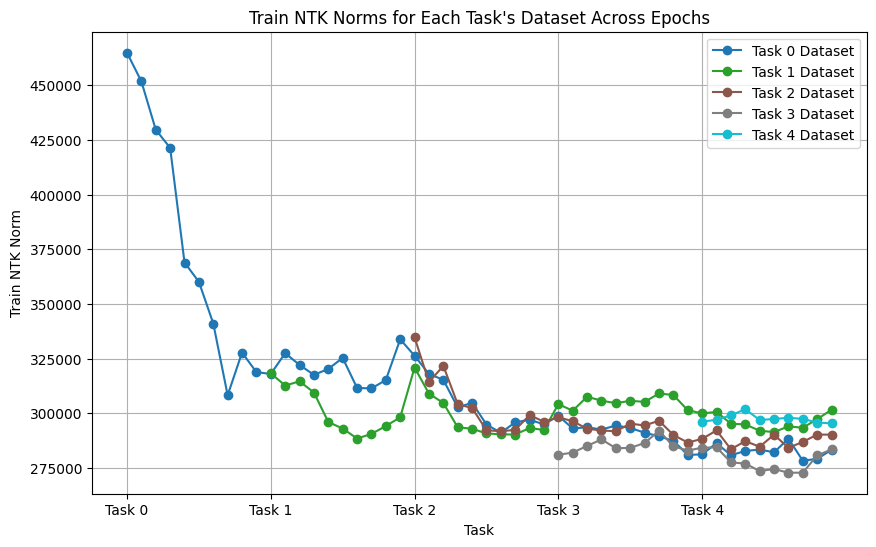

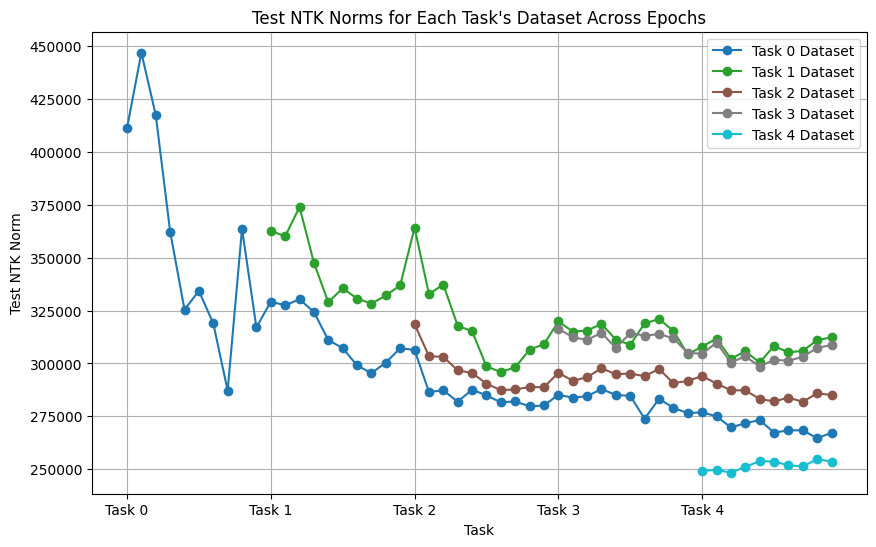

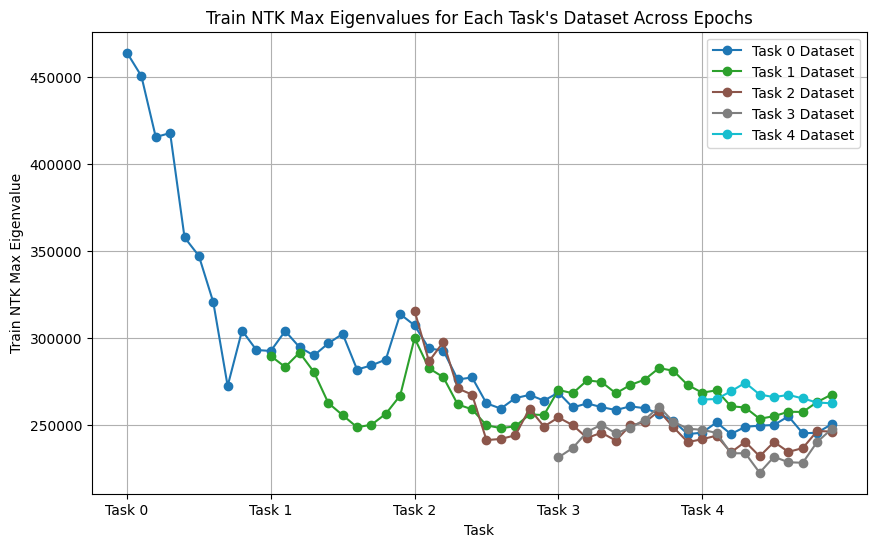

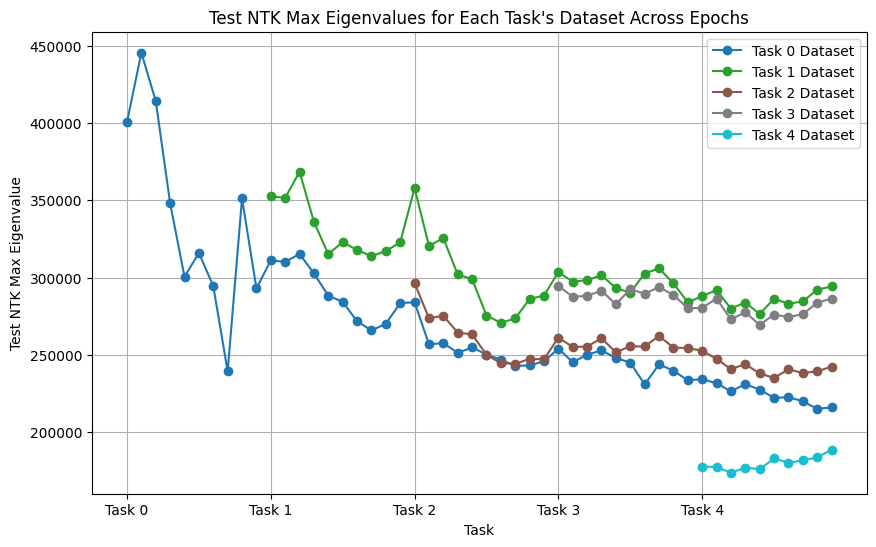

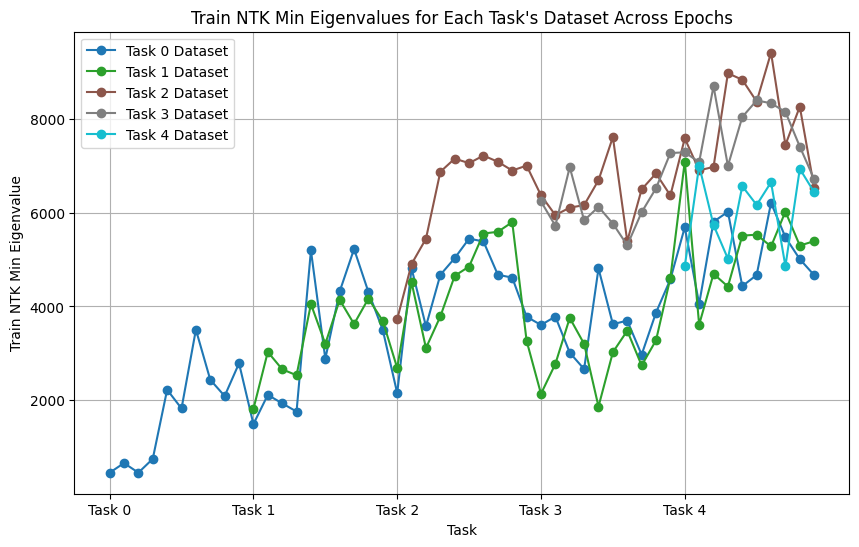

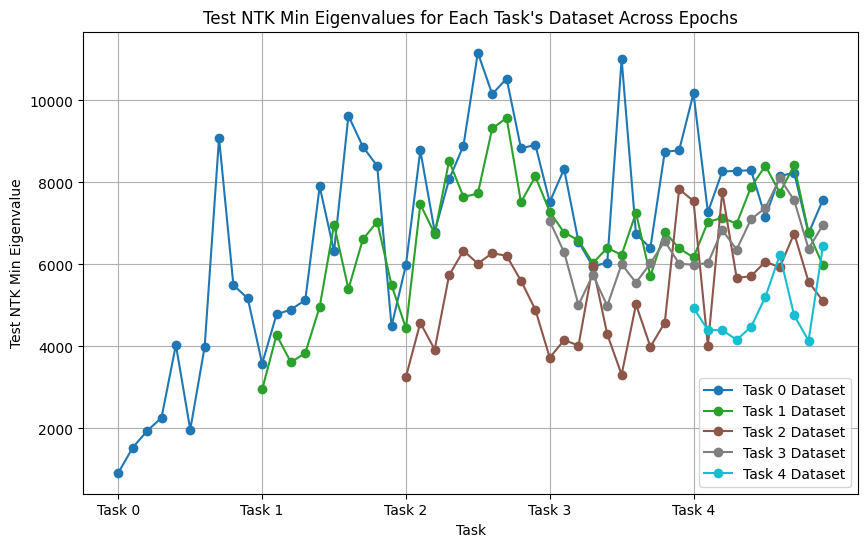

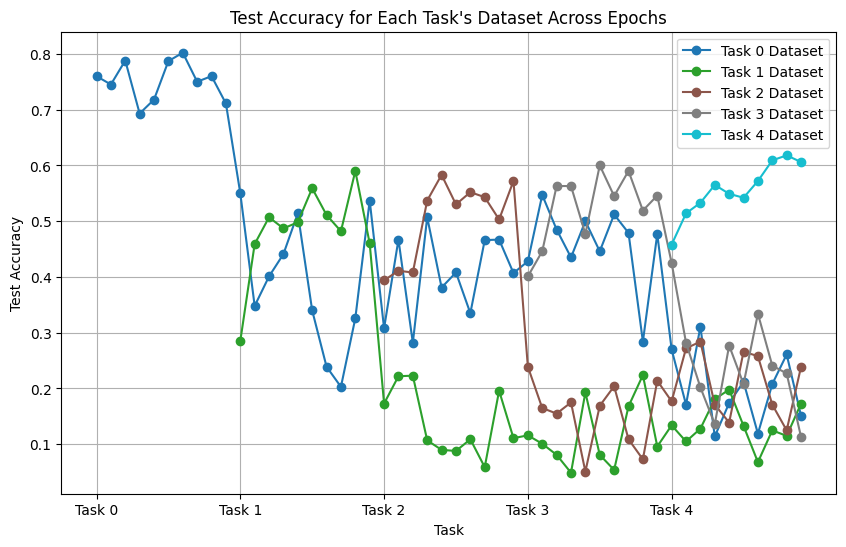

In [2]:
layer_sizes_list = [
    [32 * 32 * 3] + [5000] * 3 + [10]
    
]

metrics = {
    "MLP":{
        "CIFAR10": {
            "2-2-10": {
                "5000": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None}
            }
        }
    }
}

for layer_sizes in layer_sizes_list:
    width = layer_sizes[1]  
    model = NN(layer_sizes).to(device) 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs_per_task = 10

    train_ntk_matrices, test_ntk_matrices, task_accuracies = train_and_evaluate_with_buffer(model, epochs_per_task)

    metrics["MLP"]["CIFAR10"]["2-2-10"][str(width)] = {
        "train_ntk_matrices": train_ntk_matrices,
        "test_ntk_matrices": test_ntk_matrices,
        "task_accuracies": task_accuracies
    }
    
import pickle 
with open("mlp_cifar10_replay_2_2_10epo_cuda.pkl", "wb") as file:
    pickle.dump(metrics, file)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from continuum import ClassIncremental
from continuum.datasets import CIFAR100, CIFAR10
from continuum.tasks import split_train_val
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = CIFAR10("my/data/path", download=True, train=True)

# Define the class-incremental scenario
scenario = ClassIncremental(
    dataset,
    increment=2,  # Add 2 new classes per task
    initial_increment=2  # Start with 2 classes
)

print(f"Number of classes: {scenario.nb_classes}.")
print(f"Number of tasks: {scenario.nb_tasks}.")

# Define the NN model
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_channel):
        super(CNN, self).__init__()
        self.conv_layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_dim, num_channel, kernel_size=5),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.conv_layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channel, num_channel, kernel_size=3),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.pool1 = torch.nn.MaxPool2d((2, 2), stride=(2, 2))
        self.conv_layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channel, num_channel, kernel_size=3),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.conv_layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channel, num_channel, kernel_size=3),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.backbone = nn.Sequential(
            self.conv_layer1,
            self.conv_layer2,
            self.pool1,
            self.conv_layer3,
            self.conv_layer4,
            nn.Flatten(start_dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(num_channel*9*9, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()
    accuracy = correct / len(labels)
    return accuracy.item()

# Function to calculate NTK (based on simrnn_ntk)
def simrnn_ntk(inputseqs, model):
    grads = []
    for seq in inputseqs:
        model.zero_grad()  # Clear previous gradients
        out = model(seq.unsqueeze(0).to(device))  # Add batch dimension and move to GPU
        # Ensure output is a scalar for backward()
        if out.dim() > 0:
            out = out.sum()
        out.backward()  # Compute gradients
        # Collect gradients for all parameters
        grad = torch.cat([p.grad.flatten() if p.grad is not None else torch.zeros_like(p).flatten()
                          for p in model.parameters()])
        grads.append(grad)
    
    batchsize = len(inputseqs)
    ntk = torch.zeros(batchsize, batchsize, device=device)
    for i in range(batchsize):
        for j in range(0, i+1):
            ntk[i, j] = ntk[j, i] = torch.dot(grads[i], grads[j])
    return ntk.cpu().numpy()  # Move NTK matrix back to CPU for plotting

# Function to evaluate the model on a dataset
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)  # Move data to GPU
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total

# Lists to store fixed samples and validation tasksets
fixed_train_samples = []
fixed_val_samples = []
val_tasksets = []
train_tasksets = []

# Function to extract fixed samples and validation tasksets
def extract_fixed_samples_and_tasksets(scenario):
    for task_id, train_taskset in enumerate(scenario):
        # Split the taskset into training and validation sets
        train_taskset, val_taskset = split_train_val(train_taskset, val_split=0.1)
        
        # Store fixed samples for NTK calculation
        fixed_train_samples.append([train_taskset[i][0].to(device) for i in range(10)])  # Move to GPU
        fixed_val_samples.append([val_taskset[i][0].to(device) for i in range(10)])  # Move to GPU
        
        # Store validation taskset
        val_tasksets.append(val_taskset)
        train_tasksets.append(train_taskset)

def create_replay_dataloader(tid,sample_num=2000,batch_size=32):
    all_sample_data = [d for d in train_tasksets[tid]]
    for id in range(tid):
        task_data = [d for d in train_tasksets[id]]
        task_data_sample = random.sample(task_data,sample_num)
        all_sample_data.extend(task_data_sample)
    return DataLoader(all_sample_data, batch_size=batch_size, shuffle=True)    

# Function to train, evaluate, and plot NTK metrics
def train_and_evaluate_with_buffer(model, epochs_per_task):
    num_tasks = len(val_tasksets)
    total_epochs = num_tasks * epochs_per_task

    # Initialize lists to store results
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    task_accuracies = [[] for _ in range(num_tasks)]  # Accuracy on all tasks after each epoch
    train_ntk_matrices = [[] for _ in range(num_tasks)]
    test_ntk_matrices = [[] for _ in range(num_tasks)]

    # Train and evaluate on each task
    for task_id in range(num_tasks):
        print(f"\n=== Task {task_id + 1} ===")
        
        train_loader = DataLoader(train_tasksets[task_id], batch_size=32, shuffle=True)
        val_loader = DataLoader(val_tasksets[task_id], batch_size=32, shuffle=False)
        
        # Train the model on the current task
        model.train()
        for epoch in range(epochs_per_task):
            global_epoch = task_id * epochs_per_task + epoch  # Global epoch index
            running_loss = 0.0
            running_accuracy = 0.0
            correct = 0
            total = 0
            if task_id > 0:
                train_loader = create_replay_dataloader(task_id)
            for x, y, t in train_loader:
                x, y = x.to(device), y.to(device)  # Move data to GPU
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                
            train_loss = running_loss / len(train_loader)
            train_accuracy = correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Evaluate on the validation set
            val_loss, val_accuracy = evaluate(model, val_loader, criterion)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {global_epoch + 1}, "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Calculate NTK for fixed samples at the end of each epoch
            model.eval()
            for t in range(task_id + 1):
                train_ntk = simrnn_ntk(fixed_train_samples[t], model)
                test_ntk = simrnn_ntk(fixed_val_samples[t], model)
                train_ntk_matrices[t].append(train_ntk)
                test_ntk_matrices[t].append(test_ntk)

            # Evaluate the model on all tasks seen so far using fixed validation sets
            for t in range(task_id + 1):
                val_loader_t = DataLoader(val_tasksets[t], batch_size=32, shuffle=False)
                _, accuracy = evaluate(model, val_loader_t, criterion)
                task_accuracies[t].append(accuracy)
                print(f"Accuracy on Task {t + 1} at Epoch {global_epoch + 1}: {accuracy:.4f}")

    def calculate_ntk_metrics(ntk_matrices):
        norms = []
        max_eigenvalues = []
        min_eigenvalues = []
        for task_ntk_matrices in ntk_matrices:
            task_norms = []
            task_max_eigenvalues = []
            task_min_eigenvalues = []
            for ntk_matrix in task_ntk_matrices:
                task_norms.append(np.linalg.norm(ntk_matrix, ord='fro'))  # Use numpy.linalg.norm
                eigenvalues = np.linalg.eigvalsh(ntk_matrix)  # Use numpy.linalg.eigvalsh
                task_max_eigenvalues.append(eigenvalues[-1])
                task_min_eigenvalues.append(eigenvalues[0])
            norms.append(task_norms)
            max_eigenvalues.append(task_max_eigenvalues)
            min_eigenvalues.append(task_min_eigenvalues)
        return norms, max_eigenvalues, min_eigenvalues

    # Calculate NTK metrics for train and test NTK matrices
    train_ntk_norms, train_ntk_max_eigenvalues, train_ntk_min_eigenvalues = calculate_ntk_metrics(train_ntk_matrices)
    test_ntk_norms, test_ntk_max_eigenvalues, test_ntk_min_eigenvalues = calculate_ntk_metrics(test_ntk_matrices)

        
    def plot_ntk_metrics(ntk_metrics, title, ylabel):
        plt.figure(figsize=(10, 6))
        colors = plt.cm.tab10(np.linspace(0, 1, len(ntk_metrics)))  # Assign a color to each task

        for t in range(len(ntk_metrics)):
            # Extract NTK metrics for Task t's dataset
            ntk_metrics_task = ntk_metrics[t]

            # The x-axis starts from the epoch when the task was introduced
            x_values = range(t * epochs_per_task, total_epochs)
            y_values = ntk_metrics_task

            # Plot the curve for Task t's dataset
            plt.plot(x_values, y_values, marker='o', label=f'Task {t} Dataset', color=colors[t])

        # Customize x-axis ticks and labels
        xticks = np.arange(0, total_epochs, epochs_per_task)  # Set ticks at the start of each task
        xticklabels = [f"Task {i}" for i in range(len(xticks))]  # Label ticks as Task 0, Task 1, etc.
        plt.xticks(xticks, xticklabels)  # Apply custom ticks and labels

        plt.xlabel('Task')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot NTK norms
    plot_ntk_metrics(train_ntk_norms, title='Train NTK Norms for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Norm')
    plot_ntk_metrics(test_ntk_norms, title='Test NTK Norms for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Norm')

    # Plot NTK max eigenvalues
    plot_ntk_metrics(train_ntk_max_eigenvalues, title='Train NTK Max Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Max Eigenvalue')
    plot_ntk_metrics(test_ntk_max_eigenvalues, title='Test NTK Max Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Max Eigenvalue')

    # Plot NTK min eigenvalues
    plot_ntk_metrics(train_ntk_min_eigenvalues, title='Train NTK Min Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Min Eigenvalue')
    plot_ntk_metrics(test_ntk_min_eigenvalues, title='Test NTK Min Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Min Eigenvalue')

    # Plot task accuracies
    plot_ntk_metrics(task_accuracies, title='Test Accuracy for Each Task\'s Dataset Across Epochs', ylabel='Test Accuracy')

    return train_ntk_matrices, test_ntk_matrices, task_accuracies

# Example usage:
# First, extract fixed samples and tasksets
extract_fixed_samples_and_tasksets(scenario)


Using device: cuda
Files already downloaded and verified
Number of classes: 10.
Number of tasks: 5.



=== Task 1 ===
Epoch 1, Train Loss: 0.3431, Val Loss: 0.2314, Train Accuracy: 0.8573, Val Accuracy: 0.9060
Accuracy on Task 1 at Epoch 1: 0.9060
Epoch 2, Train Loss: 0.2226, Val Loss: 0.1725, Train Accuracy: 0.9091, Val Accuracy: 0.9300
Accuracy on Task 1 at Epoch 2: 0.9300
Epoch 3, Train Loss: 0.1501, Val Loss: 0.1628, Train Accuracy: 0.9431, Val Accuracy: 0.9440
Accuracy on Task 1 at Epoch 3: 0.9440
Epoch 4, Train Loss: 0.1177, Val Loss: 0.2462, Train Accuracy: 0.9537, Val Accuracy: 0.9210
Accuracy on Task 1 at Epoch 4: 0.9210
Epoch 5, Train Loss: 0.0962, Val Loss: 0.1879, Train Accuracy: 0.9640, Val Accuracy: 0.9460
Accuracy on Task 1 at Epoch 5: 0.9460
Epoch 6, Train Loss: 0.0689, Val Loss: 0.1764, Train Accuracy: 0.9741, Val Accuracy: 0.9350
Accuracy on Task 1 at Epoch 6: 0.9350
Epoch 7, Train Loss: 0.0582, Val Loss: 0.1619, Train Accuracy: 0.9787, Val Accuracy: 0.9440
Accuracy on Task 1 at Epoch 7: 0.9440
Epoch 8, Train Loss: 0.0590, Val Loss: 0.1881, Train Accuracy: 0.9789, Val

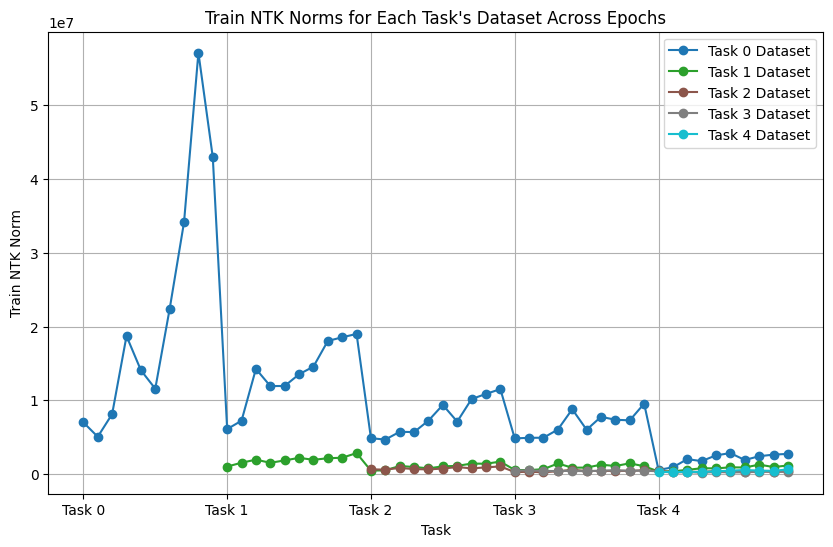

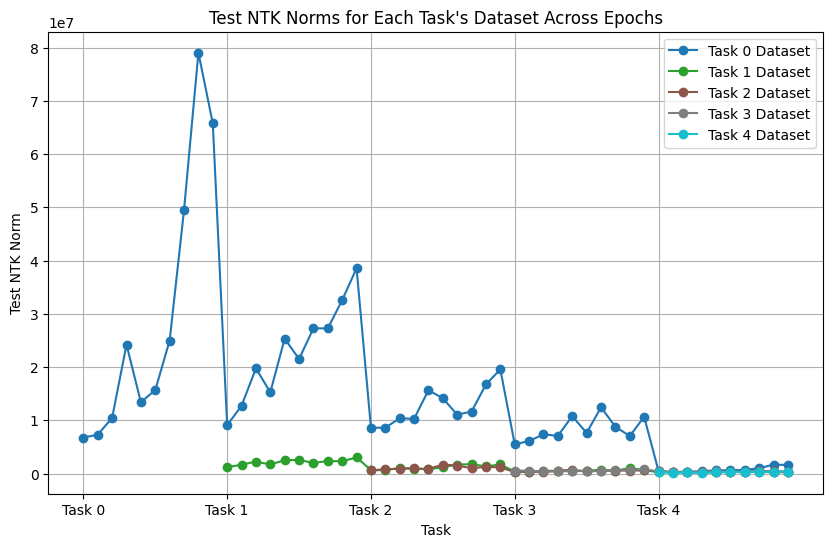

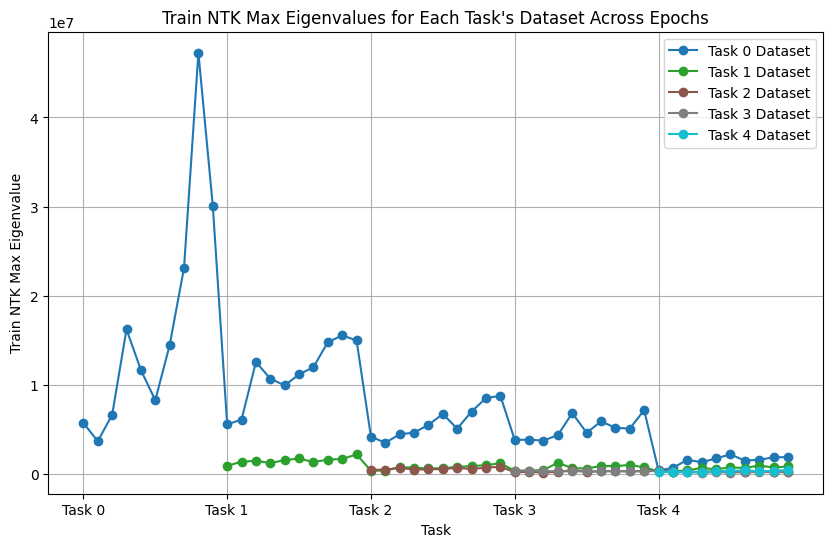

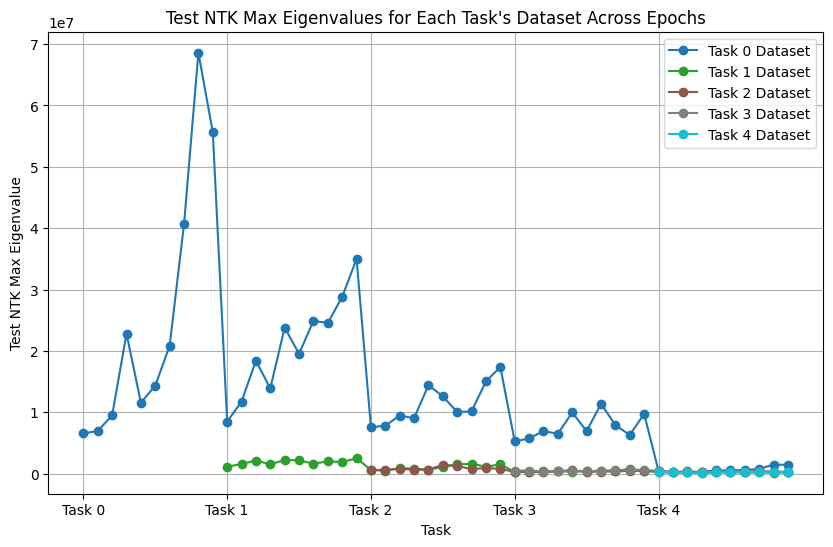

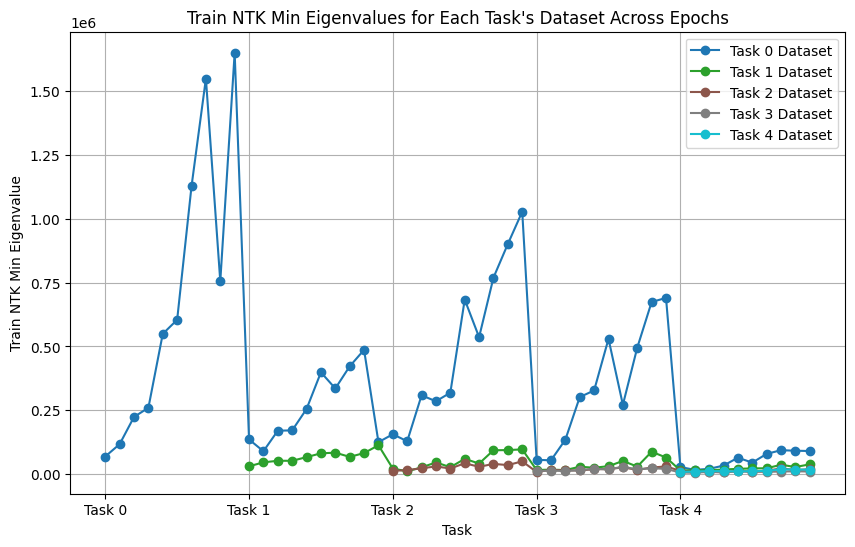

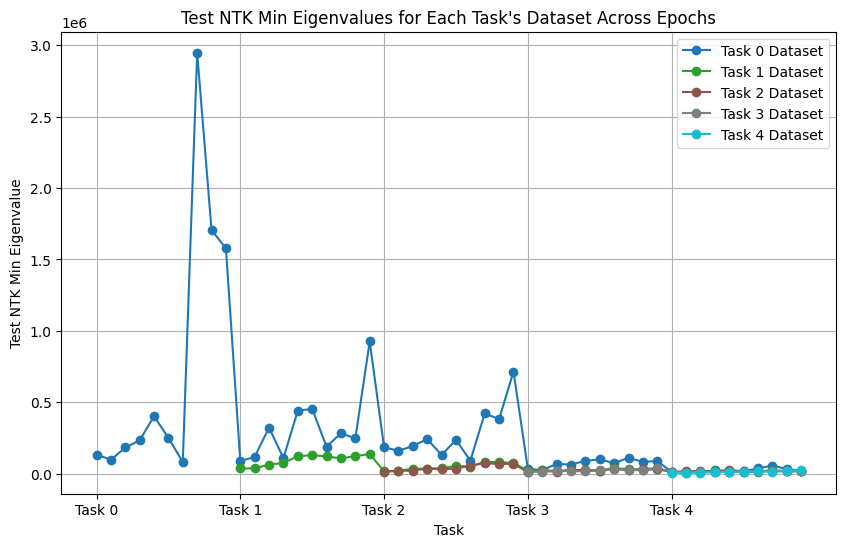

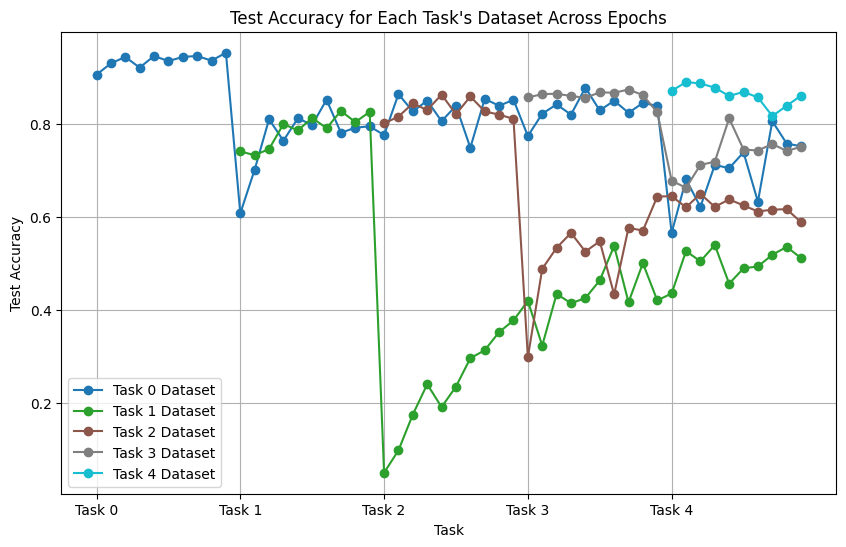


=== Task 1 ===
Epoch 1, Train Loss: 0.5128, Val Loss: 0.2015, Train Accuracy: 0.8431, Val Accuracy: 0.9130
Accuracy on Task 1 at Epoch 1: 0.9130
Epoch 2, Train Loss: 0.2531, Val Loss: 0.2044, Train Accuracy: 0.8986, Val Accuracy: 0.9180
Accuracy on Task 1 at Epoch 2: 0.9180
Epoch 3, Train Loss: 0.1764, Val Loss: 0.1872, Train Accuracy: 0.9312, Val Accuracy: 0.9270
Accuracy on Task 1 at Epoch 3: 0.9270
Epoch 4, Train Loss: 0.1460, Val Loss: 0.1334, Train Accuracy: 0.9460, Val Accuracy: 0.9510
Accuracy on Task 1 at Epoch 4: 0.9510
Epoch 5, Train Loss: 0.1093, Val Loss: 0.1389, Train Accuracy: 0.9580, Val Accuracy: 0.9420
Accuracy on Task 1 at Epoch 5: 0.9420
Epoch 6, Train Loss: 0.0851, Val Loss: 0.1390, Train Accuracy: 0.9683, Val Accuracy: 0.9500
Accuracy on Task 1 at Epoch 6: 0.9500
Epoch 7, Train Loss: 0.0737, Val Loss: 0.1570, Train Accuracy: 0.9714, Val Accuracy: 0.9430
Accuracy on Task 1 at Epoch 7: 0.9430
Epoch 8, Train Loss: 0.0630, Val Loss: 0.1796, Train Accuracy: 0.9784, Val

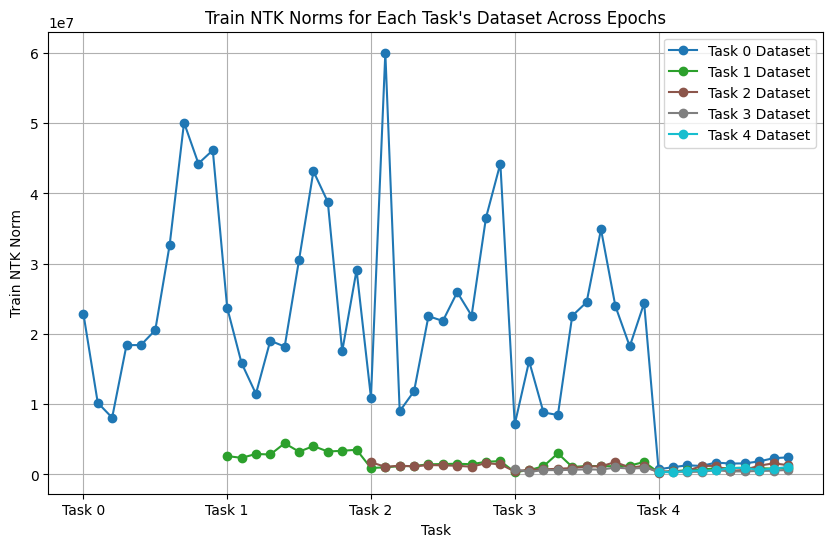

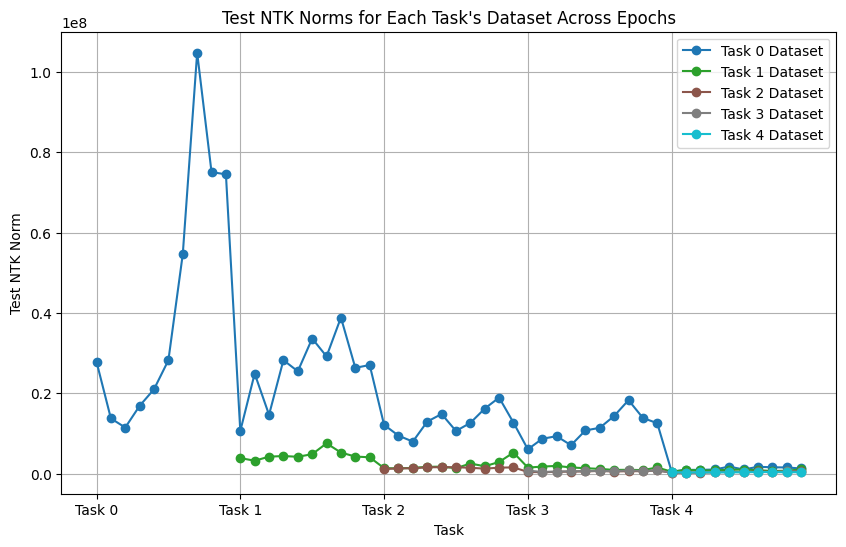

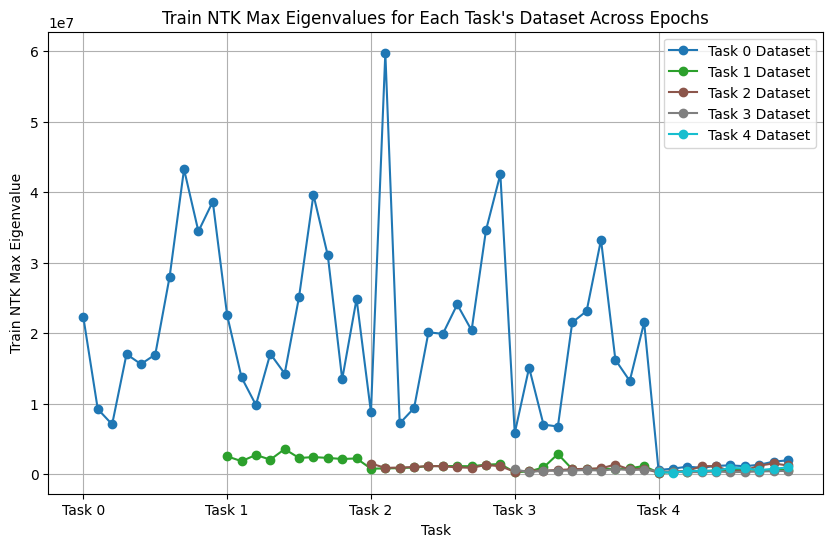

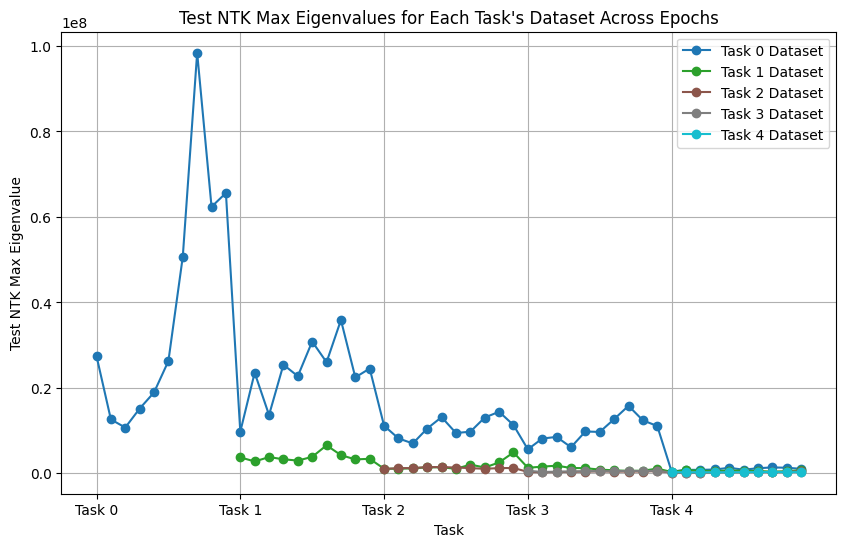

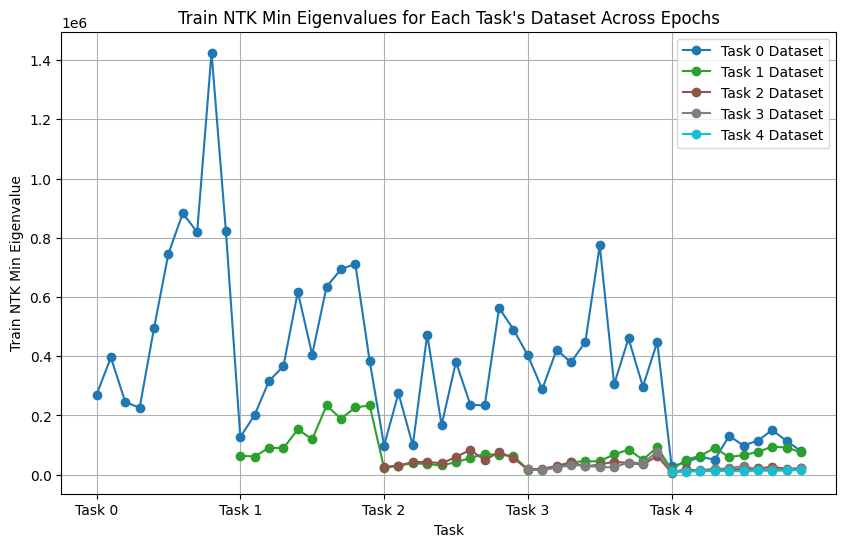

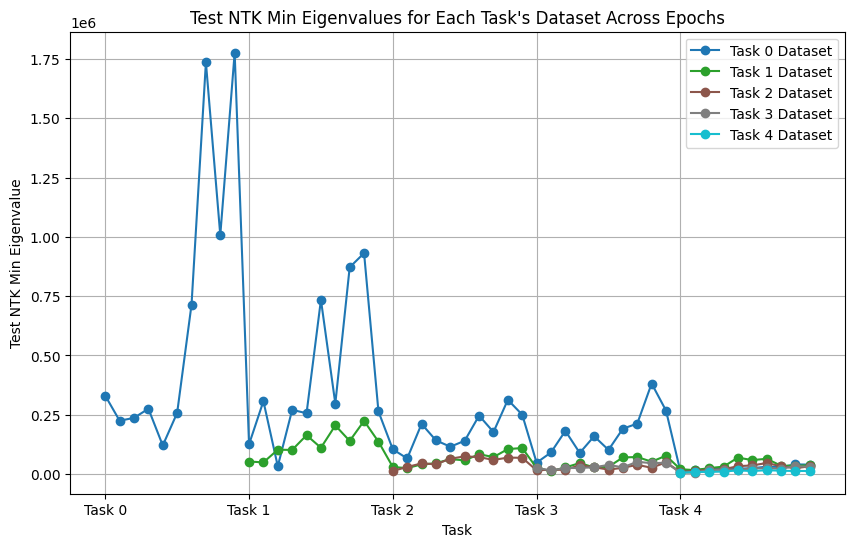

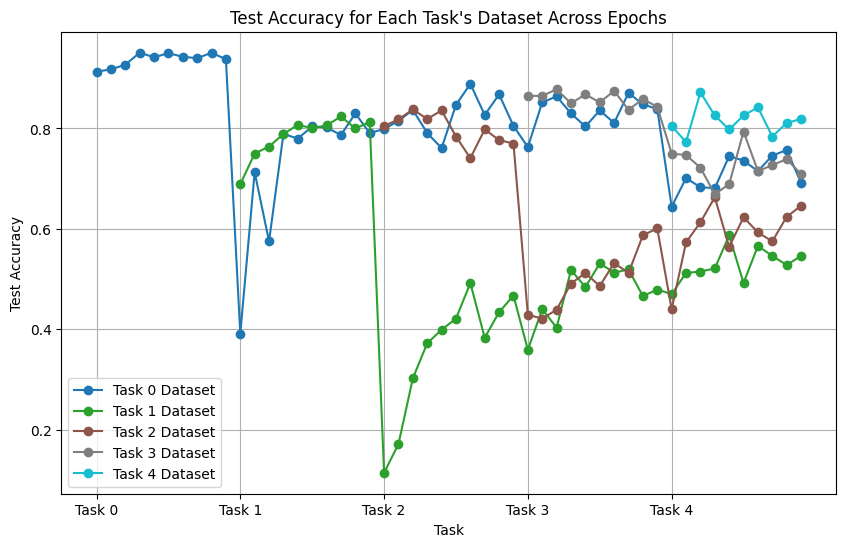

In [4]:
layer_sizes_list = [
    [3,1000,10,64],
    [3,5000,10,64],
]

metrics = {
    "CNN":{
        "CIFAR10": {
            "10-10-10": {
                "1000_64": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "5000_64": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None}
            }
        }
    }
}

for layer_sizes in layer_sizes_list:
    width = layer_sizes[1]  
    input_dim, hidden_dim, output_dim, channel = layer_sizes
    model = CNN(input_dim, hidden_dim, output_dim, channel ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs_per_task = 10

    train_ntk_matrices, test_ntk_matrices, task_accuracies = train_and_evaluate_with_buffer(model, epochs_per_task)

    metrics["CNN"]["CIFAR10"]["10-10-10"][str(width)] = {
        "train_ntk_matrices": train_ntk_matrices,
        "test_ntk_matrices": test_ntk_matrices,
        "task_accuracies": task_accuracies
    }
    
import pickle 
with open("cnn_cifar10_replay_10_10_10epo_cuda.pkl", "wb") as file:
    pickle.dump(metrics, file)